reading from parquet

In [5]:
import polars as pl
import os

# Path to processed data
processed_path = "/Users/tusharjoshi/Desktop/ProjectWorkAll/Dissertation /processed"

# Load all batches lazily (memory efficient)
df = pl.scan_parquet(f"{processed_path}/*.parquet")

# Basic counts
print("=== Basic Statistics ===")
print(f"Total records: {df.select(pl.count()).collect()[0,0]:,}")

# Unique printers
unique_printers = df.select(pl.col("id").unique()).collect()
print(f"\nUnique printers: {len(unique_printers)}")
print("\nPrinter IDs:")
for printer_id in sorted(unique_printers["id"]):
    print(f"  {printer_id}")

=== Basic Statistics ===
Total records: 94,869,699


/var/folders/n3/lvjf2dhd2xbczw56rt1rzqx80000gn/T/ipykernel_20207/3329083031.py:12: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  print(f"Total records: {df.select(pl.count()).collect()[0,0]:,}")



Unique printers: 8

Printer IDs:
  CZPX1522X017XC78087
  CZPX1522X017XC78307
  CZPX1622X017XC78384
  CZPX1622X017XC78456
  CZPX1622X017XC78491
  CZPX4521X017XC64043
  CZPX4721X017XC66125
  CZPX4921X017XC67390


<h3>records per printer
</h3>

In [6]:
# Records per printer
print("\nRecords per printer:")
printer_counts = (
    df.group_by("id")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    .collect()
)

for row in printer_counts.iter_rows():
    printer_id, count = row
    percentage = (count / 94_869_699) * 100
    print(f"  {printer_id}: {count:,} ({percentage:.1f}%)")


Records per printer:
  CZPX4521X017XC64043: 13,588,541 (14.3%)
  CZPX1622X017XC78456: 13,579,643 (14.3%)
  CZPX4921X017XC67390: 13,571,114 (14.3%)
  CZPX1622X017XC78384: 13,562,963 (14.3%)
  CZPX1522X017XC78087: 13,556,040 (14.3%)
  CZPX1622X017XC78491: 13,535,509 (14.3%)
  CZPX1522X017XC78307: 11,737,619 (12.4%)
  CZPX4721X017XC66125: 1,738,270 (1.8%)


<h3>checking the date range </h3>

In [7]:
# Overall date range
date_range = df.select([
    pl.col("date").min().alias("start_date"),
    pl.col("date").max().alias("end_date")
]).collect()

print("\nOverall date range:")
print(f"  Start: {date_range['start_date'][0]}")
print(f"  End: {date_range['end_date'][0]}")

# Check date range for the low-record printer
low_printer = "CZPX4721X017XC66125"
low_printer_dates = (
    df.filter(pl.col("id") == low_printer)
    .select([
        pl.col("date").min().alias("start"),
        pl.col("date").max().alias("end")
    ])
    .collect()
)

print(f"\nDate range for {low_printer}:")
print(f"  Start: {low_printer_dates['start'][0]}")
print(f"  End: {low_printer_dates['end'][0]}")


Overall date range:
  Start: 2024-04-03T12:27:00.652Z
  End: 2025-04-29T23:00:01.363Z

Date range for CZPX4721X017XC66125:
  Start: 2025-01-29T15:08:55.254Z
  End: 2025-03-10T23:59:58.706Z


<h3>failed vs success check</h3>

In [7]:
# Check status distribution
print("\nCheck status distribution:")
check_dist = (
    df.group_by("check")
    .agg(pl.len().alias("count"))
    .collect()
)

total = 94_869_699
for row in check_dist.iter_rows():
    status, count = row
    percentage = (count / total) * 100
    print(f"  {status}: {count:,} ({percentage:.1f}%)")

# Failed records by printer
print("\nFailed records by printer:")
failed_by_printer = (
    df.filter(pl.col("check") == "failed")
    .group_by("id")
    .agg(pl.len().alias("failed_count"))
    .sort("failed_count", descending=True)
    .collect()
)

for row in failed_by_printer.iter_rows():
    printer_id, failed = row
    print(f"  {printer_id}: {failed:,}")


Check status distribution:


AttributeError: 'DataFrame' object has no attribute 'collect'

In [1]:
import polars as pl
import os

processed_path = "/Users/tusharjoshi/Desktop/ProjectWorkAll/Dissertation /processed"

# Check each batch for null checks
print("Checking all batches for null 'check' values...\n")
print(f"{'Batch':<10} {'Total Records':<15} {'Null Checks':<15} {'Percentage':<10}")
print("-" * 50)

total_nulls = 0
total_records = 0
batches_with_nulls = []

# Get all batch files sorted
batch_files = sorted([f for f in os.listdir(processed_path) if f.endswith('.parquet')])

for batch_file in batch_files:
    # Read batch
    df = pl.read_parquet(f"{processed_path}/{batch_file}")
    
    # Count nulls
    null_count = df['check'].null_count()
    batch_total = len(df)
    null_pct = (null_count / batch_total * 100) if batch_total > 0 else 0
    
    # Track totals
    total_nulls += null_count
    total_records += batch_total
    
    # Print results
    batch_num = batch_file.replace('batch_', '').replace('.parquet', '')
    print(f"{batch_num:<10} {batch_total:<15,} {null_count:<15,} {null_pct:<10.2f}%")
    
    if null_count > 0:
        batches_with_nulls.append((batch_file, null_count))

print("-" * 50)
print(f"{'TOTAL':<10} {total_records:<15,} {total_nulls:<15,} {(total_nulls/total_records*100):<10.2f}%")
print(f"\nBatches with nulls: {len(batches_with_nulls)} out of {len(batch_files)}")

Checking all batches for null 'check' values...

Batch      Total Records   Null Checks     Percentage
--------------------------------------------------
001        3,331,416       0               0.00      %
002        2,805,908       0               0.00      %
003        3,005,163       0               0.00      %
004        3,005,002       0               0.00      %
005        2,223,424       0               0.00      %
006        2,292,976       0               0.00      %
007        3,004,799       0               0.00      %
008        3,004,960       0               0.00      %
009        3,005,002       0               0.00      %
010        3,005,135       0               0.00      %
011        2,150,302       0               0.00      %
012        2,230,298       0               0.00      %
013        3,004,981       0               0.00      %
014        3,004,567       0               0.00      %
015        3,005,184       0               0.00      %
016        2,673,293 

In [2]:
# Verify we're looking at the right data
import os
from datetime import datetime

processed_path = "/Users/tusharjoshi/Desktop/ProjectWorkAll/Dissertation /processed"

# Check file timestamps
print("Checking file creation times...\n")
print(f"{'File':<20} {'Modified Time':<25} {'Size (MB)':<10}")
print("-" * 60)

for i in range(1, 6):  # Check first 5 files
    file_path = f"{processed_path}/batch_{i:03d}.parquet"
    if os.path.exists(file_path):
        mod_time = datetime.fromtimestamp(os.path.getmtime(file_path))
        size_mb = os.path.getsize(file_path) / (1024 * 1024)
        print(f"batch_{i:03d}.parquet{' ':<5} {mod_time.strftime('%Y-%m-%d %H:%M:%S'):<25} {size_mb:<10.2f}")

# Now let's re-check the overall statistics
print("\n" + "="*60)
print("RE-CHECKING OVERALL STATISTICS WITH CLEAN DATA:")
print("="*60)

# Load all data lazily
df = pl.scan_parquet(f"{processed_path}/*.parquet")

# Check status distribution
check_dist = (
    df.group_by("check")
    .agg(pl.len().alias("count"))
    .collect()
)

print("\nCheck status distribution:")
total = 94_869_699
for row in check_dist.iter_rows():
    status, count = row
    percentage = (count / total) * 100
    print(f"  {status}: {count:,} ({percentage:.1f}%)")

Checking file creation times...

File                 Modified Time             Size (MB) 
------------------------------------------------------------
batch_001.parquet      2025-07-29 06:55:00       20.96     
batch_002.parquet      2025-07-29 06:55:01       15.14     
batch_003.parquet      2025-07-29 06:55:03       16.11     
batch_004.parquet      2025-07-29 06:55:05       16.31     
batch_005.parquet      2025-07-29 06:55:07       10.95     

RE-CHECKING OVERALL STATISTICS WITH CLEAN DATA:

Check status distribution:
  : 2,091,429 (2.2%)
  failed: 12,176,634 (12.8%)
  success: 80,601,636 (85.0%)


In [4]:
# Check ALL batches for empty string checks
print("Checking all batches for empty string 'check' values...\n")

batches_with_empty = []
total_empty = 0

for i in range(1, 35):  # All 34 batches
    try:
        df = pl.read_parquet(f"{processed_path}/batch_{i:03d}.parquet")
        
        # Count empty strings
        empty_count = (df['check'] == '').sum()
        
        if empty_count > 0:
            batches_with_empty.append(i)
            total_empty += empty_count
            print(f"Batch {i}: {empty_count:,} empty strings found")
    except:
        print(f"Batch {i}: Error reading file")

print(f"\nTotal empty strings: {total_empty:,}")
print(f"Batches with empty strings: {batches_with_empty}")

Checking all batches for empty string 'check' values...

Batch 1: 2,091,429 empty strings found

Total empty strings: 2,091,429
Batches with empty strings: [1]


In [5]:
# Load batch 1
df = pl.read_parquet(f"{processed_path}/batch_001.parquet")

print(f"Batch 1 total records: {len(df):,}")
print(f"Empty 'check' records: {(df['check'] == '').sum():,}")

# See which printers have empty checks
empty_check_df = df.filter(pl.col('check') == '')
printers_with_empty = empty_check_df.group_by('id').agg(pl.len().alias('count'))
print("\nPrinters with empty 'check' values:")
for row in printers_with_empty.iter_rows():
    print(f"  {row[0]}: {row[1]:,} records")

# Simple fix - replace empty strings with 'success'
df = df.with_columns(
    pl.when(pl.col('check') == '')
    .then(pl.lit('success')) 
    .otherwise(pl.col('check'))
    .alias('check')
)

# Save the fixed batch
df.write_parquet(f"{processed_path}/batch_001_fixed.parquet")
print("\nFixed batch saved as batch_001_fixed.parquet")

Batch 1 total records: 3,331,416
Empty 'check' records: 2,091,429

Printers with empty 'check' values:
  CZPX1522X017XC78087: 288,739 records
  CZPX4521X017XC64043: 321,236 records
  CZPX1522X017XC78307: 301,418 records
  CZPX4921X017XC67390: 303,813 records
  CZPX1622X017XC78491: 268,213 records
  CZPX1622X017XC78456: 312,346 records
  CZPX1622X017XC78384: 295,664 records

Fixed batch saved as batch_001_fixed.parquet


In [12]:
# Use lazy loading to handle schema differences
df_lazy = pl.scan_parquet(f"{processed_path}/*.parquet")

# Get check status distribution
print("Check status distribution:")
check_dist = df_lazy.group_by("check").agg(pl.len().alias("count")).collect()

# Calculate total from the aggregated results
total_records = check_dist['count'].sum()
print(f"\nTotal records (calculated): {total_records:,}")

for row in check_dist.iter_rows():
    status, count = row
    percentage = (count / total_records) * 100
    print(f"  {status}: {count:,} ({percentage:.1f}%)")

# Failed records by printer
print("\nFailed records by printer:")
failed_by_printer = (
    df_lazy.filter(pl.col("check") == "failed")
    .group_by("id")
    .agg(pl.len().alias("failed_count"))
    .sort("failed_count", descending=True)
    .collect()
)

for row in failed_by_printer.iter_rows():
    printer_id, failed = row
    print(f"  {printer_id}: {failed:,}")

Check status distribution:

Total records (calculated): 94,869,699
  failed: 12,176,634 (12.8%)
  success: 82,693,065 (87.2%)

Failed records by printer:
  CZPX1622X017XC78456: 2,050,330
  CZPX1622X017XC78491: 2,006,618
  CZPX1522X017XC78307: 1,764,592
  CZPX1522X017XC78087: 1,745,260
  CZPX4521X017XC64043: 1,707,279
  CZPX4921X017XC67390: 1,549,594
  CZPX1622X017XC78384: 1,352,887
  CZPX4721X017XC66125: 74


  Using cached matplotlib-3.10.3-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.0-cp311-cp311-macosx_10_9_universal2.whl.metadata (107 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pillow-11.3.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached pandas-2.3.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached matplotlib-3.10.3-cp311-cp311-macosx_11_0_arm64.whl (8.1 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.59.0-cp311-cp311-macosx_10_9_universal2.whl (2.8 

/var/folders/n3/lvjf2dhd2xbczw56rt1rzqx80000gn/T/ipykernel_34589/811787928.py:58: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/tusharjoshi/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


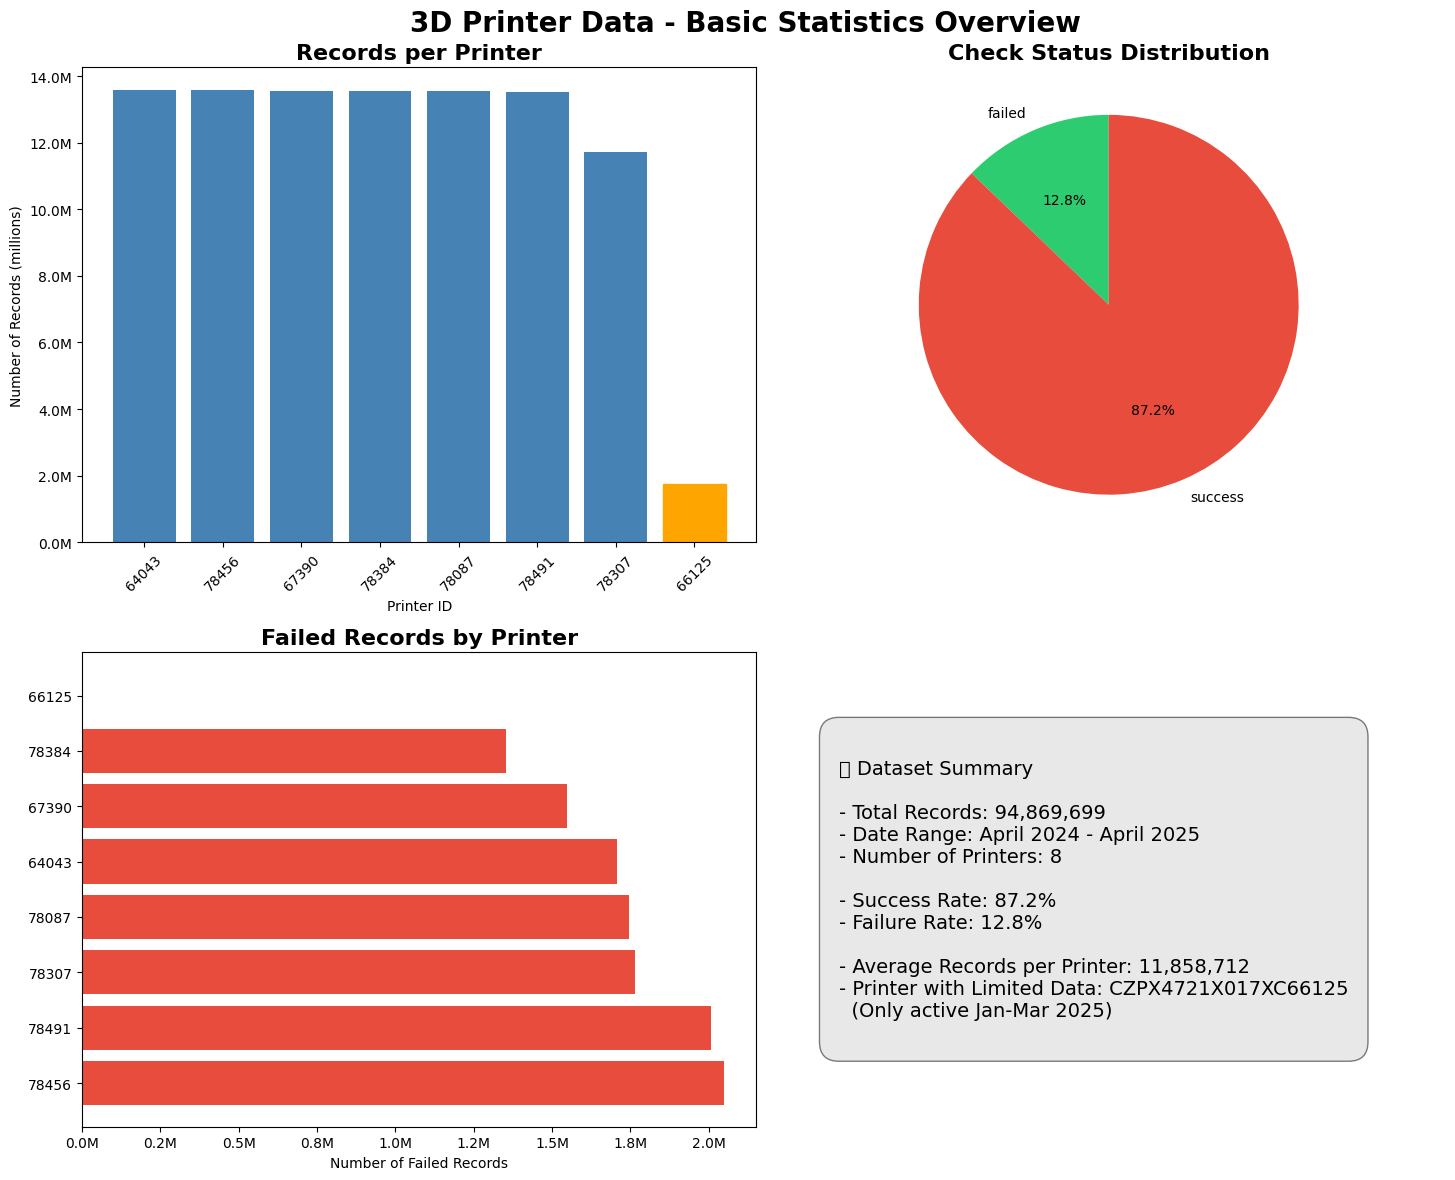

In [16]:
%pip install matplotlib seaborn


import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('default')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Records per Printer (Bar Chart)
printer_counts = df_lazy.group_by("id").agg(pl.len().alias("count")).collect().sort("count", descending=True)
bars = ax1.bar(range(len(printer_counts)), printer_counts['count'], color='steelblue')
ax1.set_xlabel('Printer ID')
ax1.set_ylabel('Number of Records (millions)')
ax1.set_title('Records per Printer', fontsize=16, fontweight='bold')
ax1.set_xticks(range(len(printer_counts)))
ax1.set_xticklabels([id[-5:] for id in printer_counts['id']], rotation=45)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Highlight the printer with few records
bars[-1].set_color('orange')

# 2. Check Status Distribution (Pie Chart)
colors = ['#2ecc71', '#e74c3c']  # green for success, red for failed
ax2.pie(check_dist['count'], labels=check_dist['check'], autopct='%1.1f%%', 
        colors=colors, startangle=90)
ax2.set_title('Check Status Distribution', fontsize=16, fontweight='bold')

# 3. Failed Records by Printer (Horizontal Bar)
ax3.barh(range(len(failed_by_printer)), failed_by_printer['failed_count'], color='#e74c3c')
ax3.set_yticks(range(len(failed_by_printer)))
ax3.set_yticklabels([id[-5:] for id in failed_by_printer['id']])
ax3.set_xlabel('Number of Failed Records')
ax3.set_title('Failed Records by Printer', fontsize=16, fontweight='bold')
ax3.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# 4. Summary Statistics Text
ax4.axis('off')
summary_text = f"""
📊 Dataset Summary

- Total Records: {total_records:,}
- Date Range: April 2024 - April 2025
- Number of Printers: 8

- Success Rate: 87.2%
- Failure Rate: 12.8%

- Average Records per Printer: {total_records//8:,}
- Printer with Limited Data: CZPX4721X017XC66125
  (Only active Jan-Mar 2025)
"""
ax4.text(0.1, 0.5, summary_text, fontsize=14, verticalalignment='center',
         bbox=dict(boxstyle="round,pad=1", facecolor="lightgray", alpha=0.5))

plt.suptitle('3D Printer Data - Basic Statistics Overview', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

In [17]:
if 'df' in globals():
    del df
    print("✓ Deleted df")



✓ Deleted df


we have visualised and tackled the basic eda part along with missing check values issue now we move on to further eda for which we are just going to use lazy df to handle the mismatch of data types

In [3]:
# Essential imports
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define paths
processed_path = "/Users/tusharjoshi/Desktop/ProjectWorkAll/Dissertation /processed"

# Load data lazily
df_lazy = pl.scan_parquet(f"{processed_path}/*.parquet")

# Define sensor fields for later use
sensor_fields = ['state', 'tempBed', 'targetBed', 'tempNozzle', 'targetNozzle', 
                'axisZ', 'axisX', 'axisY', 'flow', 'speed', 'fanHotend', 'fanPrint']

state distribution analysis

In [4]:
# Check a single batch to understand the data
df_batch1 = pl.read_parquet(f"{processed_path}/batch_001_fixed.parquet")

# Count states in this batch
print("State values in batch 1:")
state_counts = df_batch1['state'].value_counts()
print(state_counts)

# Check for nulls
null_count = df_batch1['state'].null_count()
print(f"\nNull states: {null_count}")

State values in batch 1:
shape: (6, 2)
┌──────────┬─────────┐
│ state    ┆ count   │
│ ---      ┆ ---     │
│ str      ┆ u32     │
╞══════════╪═════════╡
│ STOPPED  ┆ 118     │
│ PRINTING ┆ 273590  │
│ BUSY     ┆ 601     │
│ IDLE     ┆ 1396422 │
│ PAUSED   ┆ 37192   │
│ FINISHED ┆ 1623493 │
└──────────┴─────────┘

Null states: 0


In [5]:
# Process all batches and combine results
all_states = {}

for i in range(1, 35):  # All 34 batches
    try:
        df = pl.read_parquet(f"{processed_path}/batch_{i:03d}.parquet")
        state_counts = df['state'].value_counts()
        
        # Add to our total
        for row in state_counts.iter_rows():
            state, count = row
            if state not in all_states:
                all_states[state] = 0
            all_states[state] += count
    except:
        print(f"Error in batch {i}")

# Show results
total = sum(all_states.values())
print(f"Total records with states: {total:,}\n")
print("State distribution across ALL data:")
for state, count in sorted(all_states.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / total) * 100
    print(f"  {state}: {count:,} ({percentage:.1f}%)")

Error in batch 1
Total records with states: 91,538,283

State distribution across ALL data:
  IDLE: 39,433,091 (43.1%)
  FINISHED: 28,187,658 (30.8%)
  None: 12,033,979 (13.1%)
  BUSY: 5,568,506 (6.1%)
  PRINTING: 5,079,570 (5.5%)
  PAUSED: 505,986 (0.6%)
  ATTENTION: 441,048 (0.5%)
  STOPPED: 288,402 (0.3%)
  : 43 (0.0%)


utilization metrics

In [7]:
# 2. Calculate utilization (time spent in productive states)
productive_states = ['PRINTING', 'BUSY', 'FINISHED']
idle_states = ['IDLE', 'PAUSED', 'STOPPED']
problem_states = ['ATTENTION', None, '']

productive_count = sum(all_states.get(state, 0) for state in productive_states)
idle_count = sum(all_states.get(state, 0) for state in idle_states)
problem_count = sum(all_states.get(state, 0) for state in problem_states)

total = sum(all_states.values())

print("=== Utilization Metrics ===\n")
print(f"Productive time: {productive_count:,} records ({productive_count/total*100:.1f}%)")
print(f"Idle time: {idle_count:,} records ({idle_count/total*100:.1f}%)")
print(f"Problem/Unknown: {problem_count:,} records ({problem_count/total*100:.1f}%)")
print(f"\nOverall utilization rate: {productive_count/total*100:.1f}%")

=== Utilization Metrics ===

Productive time: 38,835,734 records (42.4%)
Idle time: 40,227,479 records (43.9%)
Problem/Unknown: 12,475,070 records (13.6%)

Overall utilization rate: 42.4%


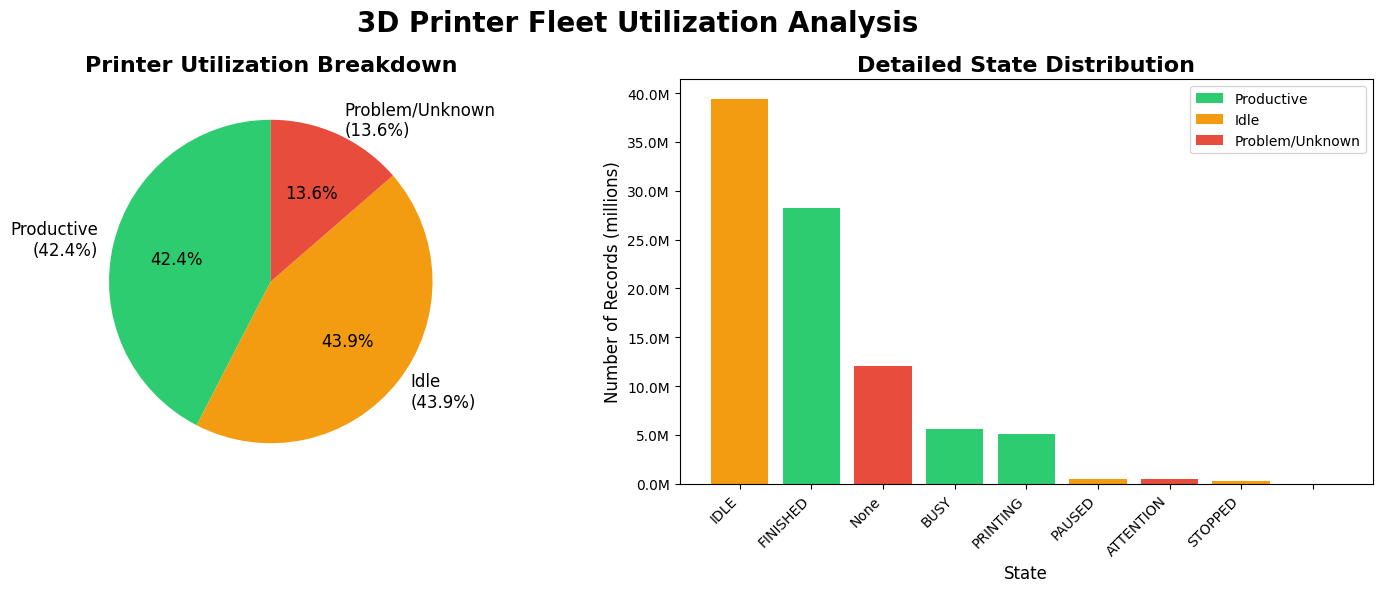


🔍 KEY FINDINGS:
• Less than half the time (42.4%) is spent productively
• Significant idle time (43.9%) indicates scheduling inefficiencies
• 13.6% of records have data quality issues
• Only 5.5% of time spent actually printing!


In [8]:
import matplotlib.pyplot as plt

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. Utilization Pie Chart
utilization_data = [productive_count, idle_count, problem_count]
utilization_labels = ['Productive\n(42.4%)', 'Idle\n(43.9%)', 'Problem/Unknown\n(13.6%)']
colors = ['#2ecc71', '#f39c12', '#e74c3c']  # green, orange, red

ax1.pie(utilization_data, labels=utilization_labels, colors=colors, 
        autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})
ax1.set_title('Printer Utilization Breakdown', fontsize=16, fontweight='bold')

# 2. Detailed State Bar Chart
states = list(all_states.keys())
counts = list(all_states.values())

# Sort by count
sorted_data = sorted(zip(states, counts), key=lambda x: x[1], reverse=True)
states_sorted = [s if s is not None else 'None' for s, _ in sorted_data]
counts_sorted = [c for _, c in sorted_data]

# Color based on category
bar_colors = []
for state in [s for s, _ in sorted_data]:
    if state in productive_states:
        bar_colors.append('#2ecc71')  # green
    elif state in idle_states:
        bar_colors.append('#f39c12')  # orange
    else:
        bar_colors.append('#e74c3c')  # red

ax2.bar(range(len(states_sorted)), counts_sorted, color=bar_colors)
ax2.set_xlabel('State', fontsize=12)
ax2.set_ylabel('Number of Records (millions)', fontsize=12)
ax2.set_title('Detailed State Distribution', fontsize=16, fontweight='bold')
ax2.set_xticks(range(len(states_sorted)))
ax2.set_xticklabels(states_sorted, rotation=45, ha='right')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label='Productive'),
    Patch(facecolor='#f39c12', label='Idle'),
    Patch(facecolor='#e74c3c', label='Problem/Unknown')
]
ax2.legend(handles=legend_elements, loc='upper right')

plt.suptitle('3D Printer Fleet Utilization Analysis', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary text
print("\n🔍 KEY FINDINGS:")
print(f"• Less than half the time ({productive_count/total*100:.1f}%) is spent productively")
print(f"• Significant idle time ({idle_count/total*100:.1f}%) indicates scheduling inefficiencies")
print(f"• {problem_count/total*100:.1f}% of records have data quality issues")
print(f"• Only {all_states.get('PRINTING', 0)/total*100:.1f}% of time spent actually printing!")

state transition analysis

In [12]:
# Count state transitions across all data
print("Counting state transitions...\n")

transitions = {}

# Read each file
for i in range(1, 35):
    try:
        df = pl.read_parquet(f"{processed_path}/batch_{i:03d}.parquet")
        
        # Sort by date (important!)
        df = df.sort("date")
        
        # Look at each printer
        for printer in df["id"].unique():
            # Get this printer's data
            printer_df = df.filter(pl.col("id") == printer)
            
            # Get states as a list
            states = printer_df["state"].to_list()
            
            # Find changes
            for j in range(1, len(states)):
                before = states[j-1]
                after = states[j]
                
                # If state changed
                if before and after and before != after:
                    change = f"{before} → {after}"
                    if change not in transitions:
                        transitions[change] = 0
                    transitions[change] += 1
        
        print(f"✓ Batch {i}")
        
    except:
        print(f"✗ Batch {i} had issues")

# Show results
print(f"\nFound {sum(transitions.values())} total transitions")
print("\nMost common transitions:")
for change, count in sorted(transitions.items(), key=lambda x: x[1], reverse=True)[:15]:
    print(f"  {change}: {count:,} times")

Counting state transitions...

✓ Batch 1
✓ Batch 2
✓ Batch 3
✓ Batch 4
✓ Batch 5
✓ Batch 6
✓ Batch 7
✓ Batch 8
✓ Batch 9
✓ Batch 10
✓ Batch 11
✓ Batch 12
✓ Batch 13
✓ Batch 14
✓ Batch 15
✓ Batch 16
✓ Batch 17
✓ Batch 18
✓ Batch 19
✓ Batch 20
✓ Batch 21
✓ Batch 22
✓ Batch 23
✓ Batch 24
✓ Batch 25
✓ Batch 26
✓ Batch 27
✓ Batch 28
✓ Batch 29
✓ Batch 30
✓ Batch 31
✓ Batch 32
✓ Batch 33
✓ Batch 34

Found 5545 total transitions

Most common transitions:
  IDLE → PRINTING: 795 times
  PRINTING → FINISHED: 754 times
  BUSY → IDLE: 720 times
  IDLE → BUSY: 712 times
  FINISHED → IDLE: 629 times
  PRINTING → STOPPED: 375 times
  ATTENTION → PRINTING: 336 times
  STOPPED → IDLE: 319 times
  IDLE → ATTENTION: 282 times
  PAUSED → PRINTING: 113 times
  PRINTING → PAUSED: 112 times
  PRINTING → IDLE: 100 times
  FINISHED → PRINTING: 91 times
  STOPPED → PRINTING: 40 times
  PRINTING → ATTENTION: 40 times


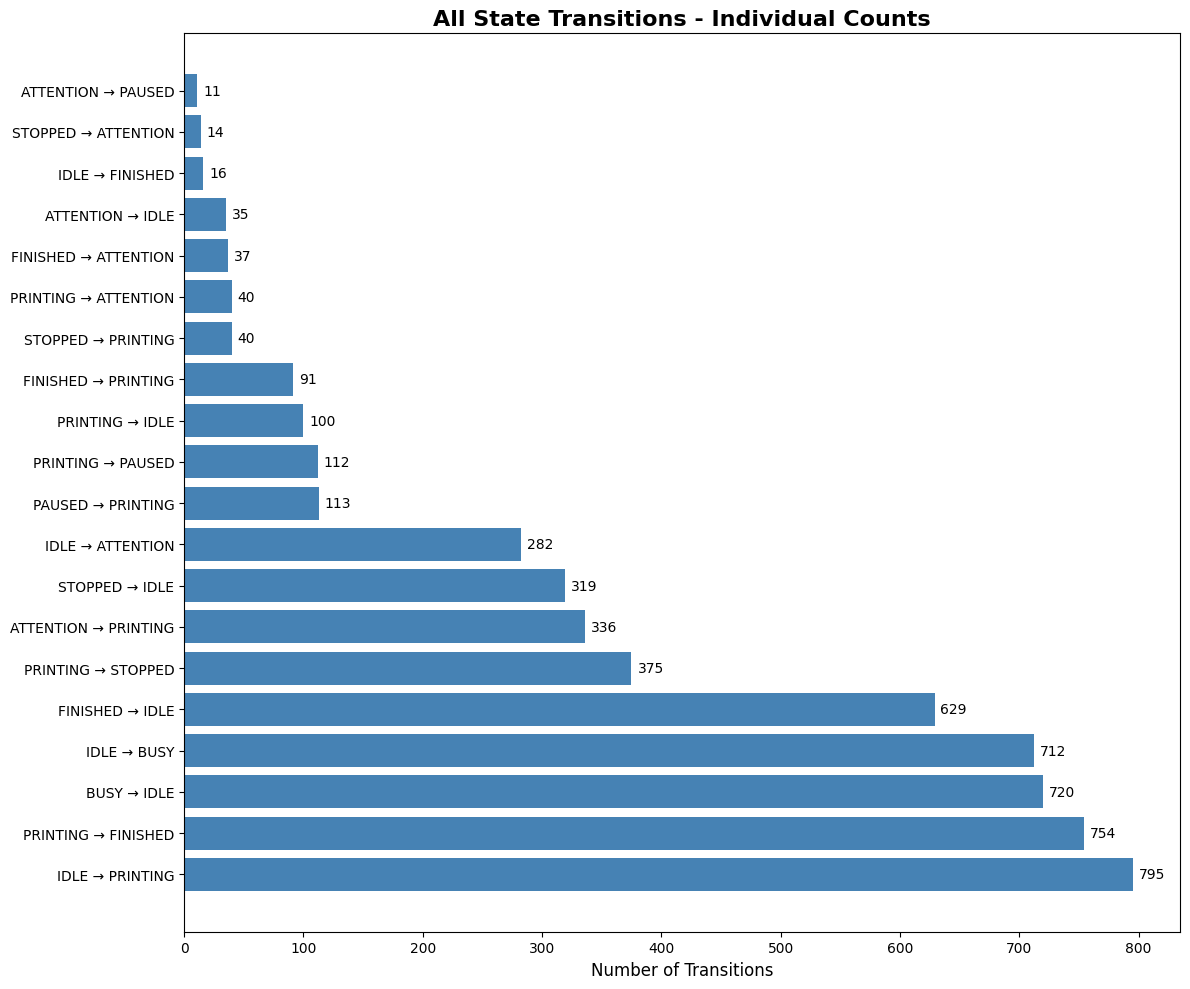

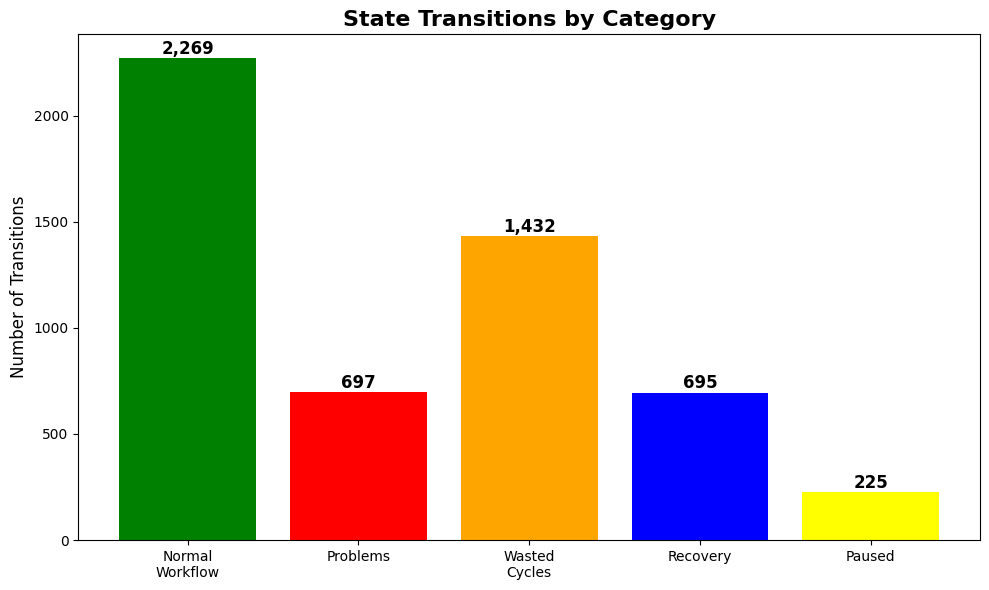

In [14]:
# Visualization 1: All Individual Transitions
plt.figure(figsize=(12, 10))

# Get all transitions sorted by count
all_transitions_sorted = sorted(transitions.items(), key=lambda x: x[1], reverse=True)[:20]  # Top 20

names = [t[0] for t in all_transitions_sorted]
counts = [t[1] for t in all_transitions_sorted]

# Create horizontal bar chart
plt.barh(range(len(names)), counts, color='steelblue')
plt.yticks(range(len(names)), names)
plt.xlabel('Number of Transitions', fontsize=12)
plt.title('All State Transitions - Individual Counts', fontsize=16, fontweight='bold')

# Add count labels
for i, count in enumerate(counts):
    plt.text(count + 5, i, str(count), va='center')

plt.tight_layout()
plt.show()

# Visualization 2: Grouped by Category
plt.figure(figsize=(10, 6))

# Define categories
normal = ['IDLE → PRINTING', 'PRINTING → FINISHED', 'FINISHED → IDLE', 'FINISHED → PRINTING']
problems = ['PRINTING → STOPPED', 'IDLE → ATTENTION', 'PRINTING → ATTENTION']
wasted = ['IDLE → BUSY', 'BUSY → IDLE']
recovery = ['ATTENTION → PRINTING', 'STOPPED → IDLE', 'STOPPED → PRINTING']
paused = ['PRINTING → PAUSED', 'PAUSED → PRINTING']

# Sum counts by category
category_counts = {
    'Normal\nWorkflow': sum(transitions.get(t, 0) for t in normal),
    'Problems': sum(transitions.get(t, 0) for t in problems),
    'Wasted\nCycles': sum(transitions.get(t, 0) for t in wasted),
    'Recovery': sum(transitions.get(t, 0) for t in recovery),
    'Paused': sum(transitions.get(t, 0) for t in paused)
}

# Plot
colors = ['green', 'red', 'orange', 'blue', 'yellow']
bars = plt.bar(category_counts.keys(), category_counts.values(), color=colors)

# Add values on bars
for bar, value in zip(bars, category_counts.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, 
             f'{value:,}', ha='center', fontsize=12, fontweight='bold')

plt.ylabel('Number of Transitions', fontsize=12)
plt.title('State Transitions by Category', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

downtime analysis 

In [15]:
# 4. Downtime Analysis - ALL BATCHES
print("=== Complete Downtime Analysis ===\n")

# Define categories
downtime_states = ['IDLE', 'STOPPED', 'ATTENTION', 'PAUSED']
productive_states = ['PRINTING', 'FINISHED', 'BUSY']

# Track downtime by printer
printer_downtime = {}
printer_productive = {}

# Process ALL batches
for i in range(1, 35):
    try:
        df = pl.read_parquet(f"{processed_path}/batch_{i:03d}.parquet")
        
        # For each printer in this batch
        for printer_id in df['id'].unique():
            printer_df = df.filter(pl.col('id') == printer_id)
            
            # Count downtime records
            downtime = printer_df.filter(pl.col('state').is_in(downtime_states)).shape[0]
            productive = printer_df.filter(pl.col('state').is_in(productive_states)).shape[0]
            
            # Add to totals
            if printer_id not in printer_downtime:
                printer_downtime[printer_id] = 0
                printer_productive[printer_id] = 0
            
            printer_downtime[printer_id] += downtime
            printer_productive[printer_id] += productive
        
        print(f"✓ Batch {i}")
        
    except:
        print(f"✗ Batch {i} skipped")

# Calculate totals
total_downtime = sum(printer_downtime.values())
total_productive = sum(printer_productive.values())
total_all = total_downtime + total_productive

print(f"\n=== OVERALL RESULTS ===")
print(f"Total downtime: {total_downtime:,} records ({total_downtime/total_all*100:.1f}%)")
print(f"Total productive: {total_productive:,} records ({total_productive/total_all*100:.1f}%)")

# Show worst performers
print("\n=== Printers with Most Downtime ===")
for printer, downtime in sorted(printer_downtime.items(), key=lambda x: x[1], reverse=True):
    total_printer = downtime + printer_productive.get(printer, 0)
    downtime_pct = (downtime / total_printer * 100) if total_printer > 0 else 0
    print(f"{printer}: {downtime:,} downtime records ({downtime_pct:.1f}% of its time)")

=== Complete Downtime Analysis ===

✓ Batch 1
✓ Batch 2
✓ Batch 3
✓ Batch 4
✓ Batch 5
✓ Batch 6
✓ Batch 7
✓ Batch 8
✓ Batch 9
✓ Batch 10
✓ Batch 11
✓ Batch 12
✓ Batch 13
✓ Batch 14
✓ Batch 15
✓ Batch 16
✓ Batch 17
✓ Batch 18
✓ Batch 19
✓ Batch 20
✓ Batch 21
✓ Batch 22
✓ Batch 23
✓ Batch 24
✓ Batch 25
✓ Batch 26
✓ Batch 27
✓ Batch 28
✓ Batch 29
✓ Batch 30
✓ Batch 31
✓ Batch 32
✓ Batch 33
✓ Batch 34

=== OVERALL RESULTS ===
Total downtime: 42,102,259 records (50.8%)
Total productive: 40,733,418 records (49.2%)

=== Printers with Most Downtime ===
CZPX4921X017XC67390: 7,443,482 downtime records (59.8% of its time)
CZPX1622X017XC78384: 6,803,227 downtime records (56.7% of its time)
CZPX1622X017XC78456: 6,739,457 downtime records (56.2% of its time)
CZPX4521X017XC64043: 6,431,135 downtime records (55.0% of its time)
CZPX1522X017XC78087: 5,742,933 downtime records (47.9% of its time)
CZPX1522X017XC78307: 4,106,471 downtime records (43.4% of its time)
CZPX1622X017XC78491: 3,822,833 downtime r

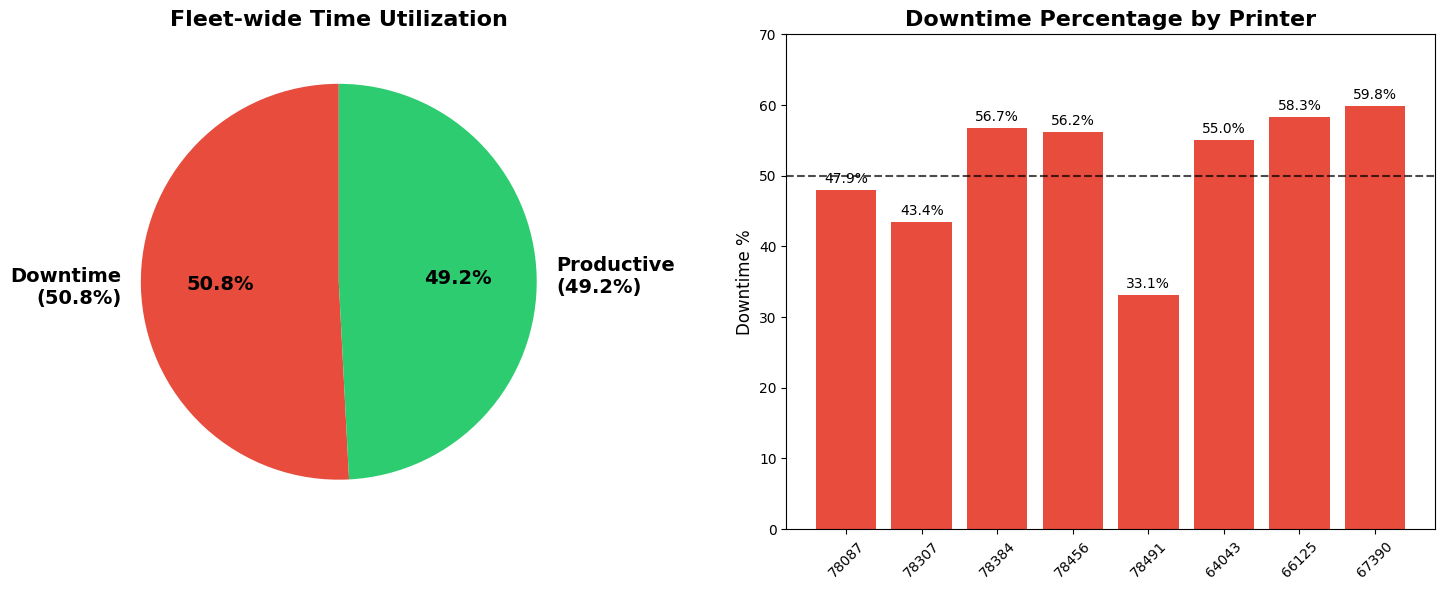


🚨 CRITICAL FINDINGS:
• Over HALF of all time is wasted in downtime!
• Best printer still has 33.1% downtime
• Worst printer has nearly 60% downtime
• Massive opportunity for efficiency improvements!


In [16]:
# Visualize downtime analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. Overall downtime vs productive pie chart
sizes = [total_downtime, total_productive]
labels = ['Downtime\n(50.8%)', 'Productive\n(49.2%)']
colors = ['#e74c3c', '#2ecc71']

ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
        startangle=90, textprops={'fontsize': 14, 'fontweight': 'bold'})
ax1.set_title('Fleet-wide Time Utilization', fontsize=16, fontweight='bold')

# 2. Downtime percentage by printer
printers = []
downtime_pcts = []

for printer in sorted(printer_downtime.keys()):
    printers.append(printer[-5:])  # Last 5 chars of ID
    total = printer_downtime[printer] + printer_productive[printer]
    pct = (printer_downtime[printer] / total * 100)
    downtime_pcts.append(pct)

bars = ax2.bar(range(len(printers)), downtime_pcts, color='#e74c3c')
ax2.axhline(y=50, color='black', linestyle='--', alpha=0.7, label='50% line')
ax2.set_xticks(range(len(printers)))
ax2.set_xticklabels(printers, rotation=45)
ax2.set_ylabel('Downtime %', fontsize=12)
ax2.set_title('Downtime Percentage by Printer', fontsize=16, fontweight='bold')
ax2.set_ylim(0, 70)

# Add value labels on bars
for bar, pct in zip(bars, downtime_pcts):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{pct:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n🚨 CRITICAL FINDINGS:")
print(f"• Over HALF of all time is wasted in downtime!")
print(f"• Best printer still has 33.1% downtime")
print(f"• Worst printer has nearly 60% downtime")
print(f"• Massive opportunity for efficiency improvements!")